### Install Required Packages

Stable Diffusion GitHub Link: https://github.com/Stability-AI/stablediffusion/blob/main/README.md

Install `xformers` and follow steps mentioned above to run faster on server

In [1]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-4c39f7e1-ad91-1ad4-e459-8dc9e1605e19)


In [2]:
%%capture
!pip install transformers
!pip install accelerate xformers  # This is to reduce model load overhead
!pip install diffusers scipy safetensors
!conda install --yes -c pytorch pytorch=1.7.1 torchvision cudatoolkit=11.0
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Load Necessary Libraries

In [16]:
# General
import os
import json
import datetime
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import clip
from numpy.linalg import norm
import shutil


# Image Processing
from PIL import Image
import cv2

# Image Generation
from transformers import CLIPTokenizer
from diffusers import StableDiffusionPipeline, EulerDiscreteScheduler
import torch

In [5]:
df=pd.read_csv('/content/drive/MyDrive/AIISC/NYT.csv')
df.head()

id                                       tweetContent  \
0  tweetImg0  A giant 150-year-old banyan tree in Lahaina, H...   
1  tweetImg1  How did you do in Connections today? You’re gi...   
2  tweetImg2  Have you ever wondered why we name hurricanes?...   
3  tweetImg3  The third annual New York Times Restaurant Lis...   
4  tweetImg4  "It is the best chili I ever made or ate. So m...   

                               tweetContentProcessed  
0  A giant 150yearold banyan tree in Lahaina Hawa...  
1  How did you do in Connections today Youre give...  
2  Have you ever wondered why we name hurricanes ...  
3  The third annual New York Times Restaurant Lis...  
4  It is the best chili I ever made or ate So muc...

In [6]:
prompts=list(df.tweetContentProcessed[:10])

In [7]:
prompts

['A giant 150yearold banyan tree in Lahaina Hawaii was badly burned in the fires that ravaged Maui last month Then green shoots began to unfurl around its trunk hinting at the possibility of recovery for the tree and the community',
 'How did you do in Connections today Youre given 16 words Your mission Identify the hidden relationships and organize them into four distinct groups of four',
 'Have you ever wondered why we name hurricanes The New York Times meteorologist Judson Jones explains',
 'The third annual New York Times Restaurant List is here It wasnt easy to narrow it down but here are the 50 best restaurants in the US',
 'It is the best chili I ever made or ate So much flavor so good This recipe makes a thick comforting chili that can be prepared in a slow cooker or in a Dutch oven on the stovetop',
 'After experiencing an unsolicited wave of viral fame the owners of the wine and ice cream bar Folderol in Paris took a number of measures to manage crowds including hiring a boun

# Image Generation


In [8]:
# Directory to store the Images
OUTPUT_DIR='Data-Generated/'
ORIGINAL_DIR='/content/drive/MyDrive/AIISC/tweetImages/'

if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

In [9]:
DIFFUSION_MODEL_PATH = "stabilityai/stable-diffusion-2-1" # Set the model path to load the diffusion model from

In [10]:
DEVICE = 'cuda' if torch.cuda.is_available else 'cpu' # device
NUM_IMAGES_PER_PROMPT = 4 # Max number of images to be generated per prompt
THRESHOLD= 0.65 # Threshold for image similarity
STRENGTH = 0.3 # The noise to add to original image
NUM_INFERENCE_STEPS = 50 # Number of inference steps to the Diffusion Model

In [11]:
CLIP,preprocess = clip.load("ViT-B/32", device=DEVICE)

100%|███████████████████████████████████████| 338M/338M [00:03<00:00, 91.5MiB/s]


In [12]:
def similarityScore(image_1,image_2):
  preprocessed_image_1 = preprocess(image_1).unsqueeze(0).to(DEVICE)
  preprocessed_image_2 = preprocess(image_2).unsqueeze(0).to(DEVICE)

  with torch.no_grad():
      features_1 = CLIP.encode_image(preprocessed_image_1).cpu().detach().numpy()
      features_2 = CLIP.encode_image(preprocessed_image_2).cpu().detach().numpy()

      cosine_similarity = np.dot(features_1,features_2.T)/(norm(features_1)*norm(features_2))
      return cosine_similarity[0][0]

In [13]:
scheduler = EulerDiscreteScheduler.from_pretrained(DIFFUSION_MODEL_PATH, subfolder="scheduler")

model = StableDiffusionPipeline.from_pretrained(DIFFUSION_MODEL_PATH, scheduler=scheduler, torch_dtype=torch.float16)
model = model.to("cuda")

# UNCOMMENT for efficient use of VRAM
# model.enable_attention_slicing() # Tradeoff between speed and memory

Fetching 12 files:   0%|          | 0/12 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

In [14]:
# Iterating over the prompts and generating Images

for i,prompt in enumerate(prompts):
  max_score = 0
  idx = str(df.id[i])
  image_path =  ORIGINAL_DIR + idx + '.jpg'
  original_image = Image.open(image_path)

  for j in range(NUM_IMAGES_PER_PROMPT):

    output_image = model(prompt, num_inference_steps=NUM_INFERENCE_STEPS).images[0]
    score = similarityScore(output_image, original_image)

    if score > THRESHOLD:
      output_image.save(f'{OUTPUT_DIR}/{idx}.jpg')
      break
    else:
      if score > max_score:
        max_score = score
        output_image.save(f'{OUTPUT_DIR}/{idx}.jpg')
      else : continue


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

# Visualization

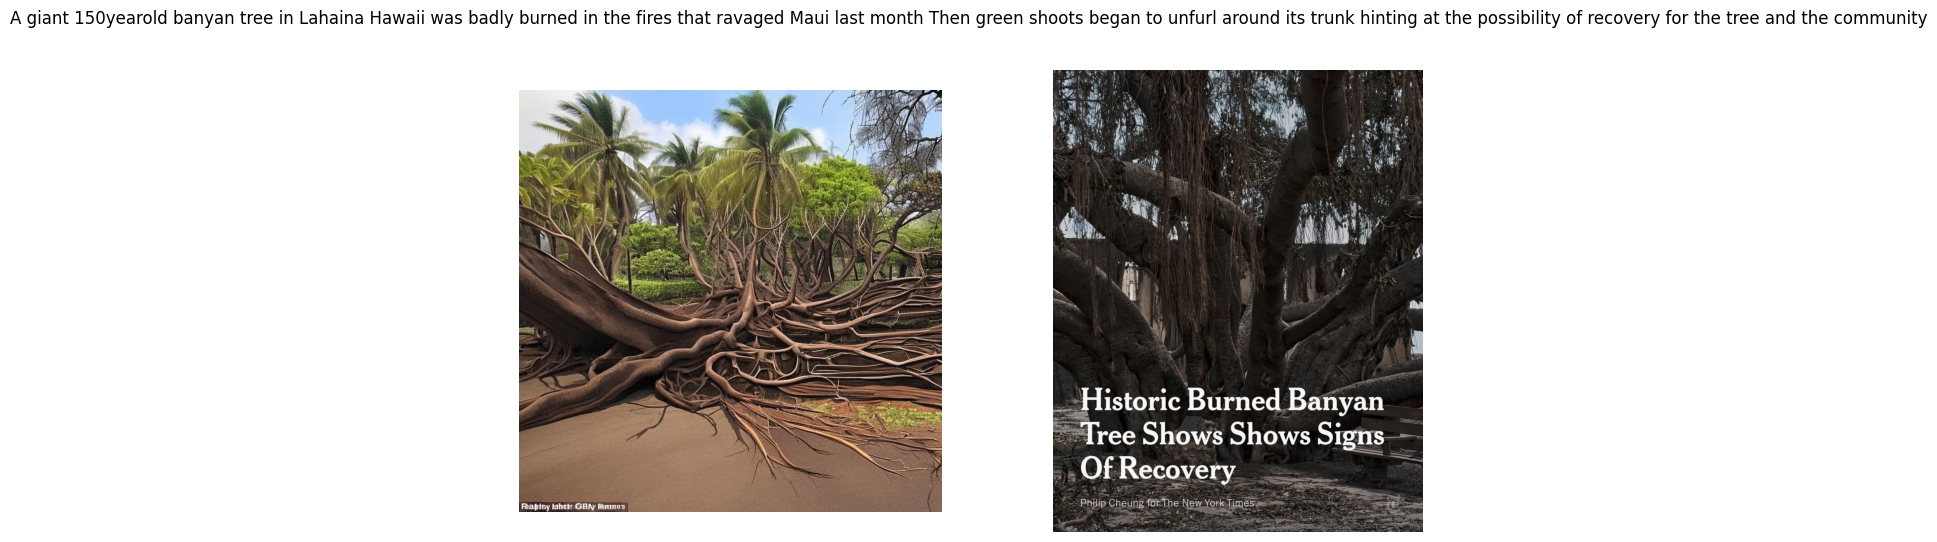

Similarity Score:0.45654296875


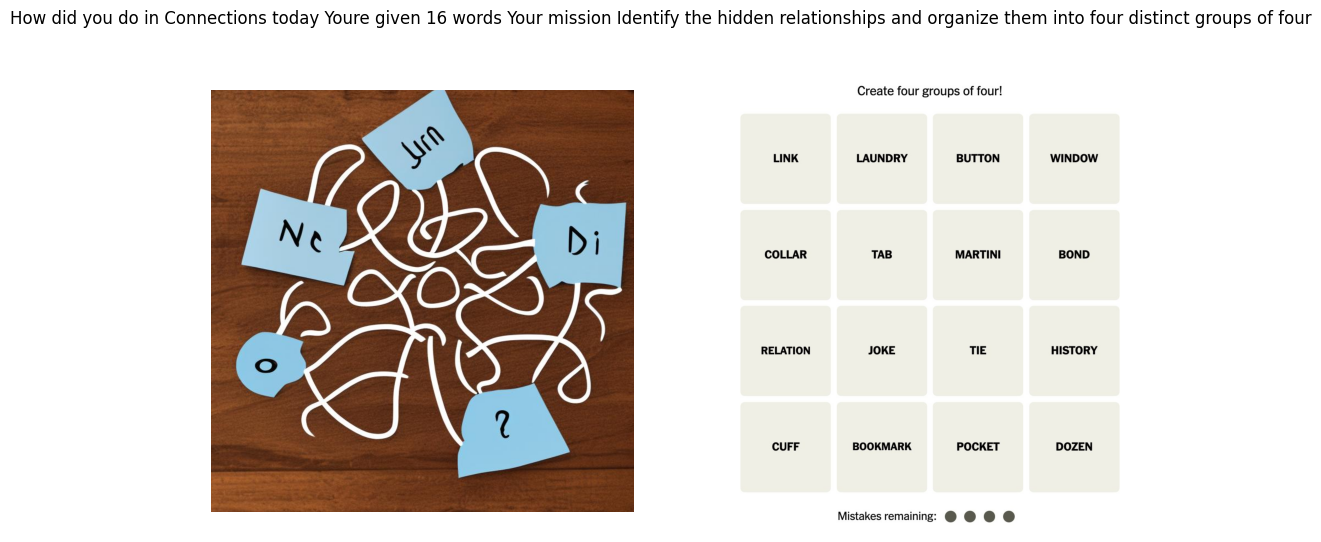

Similarity Score:0.57861328125


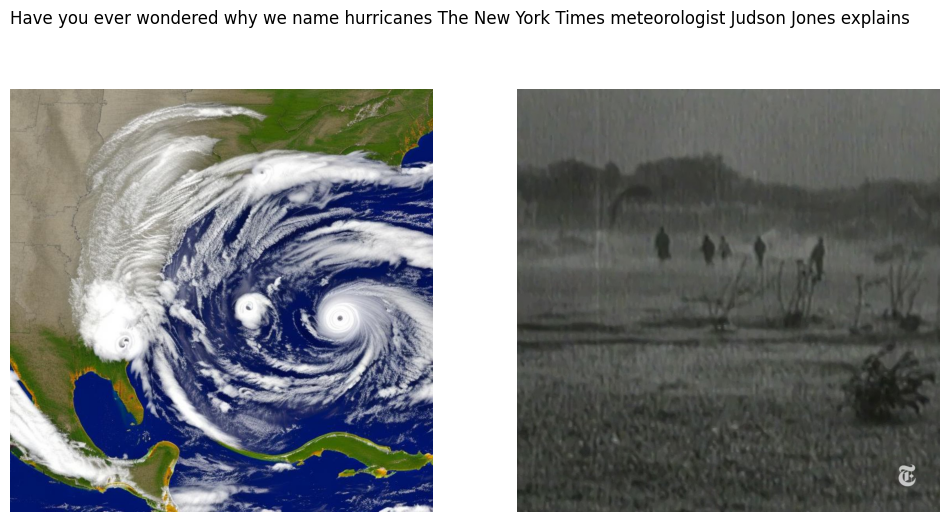

Similarity Score:0.50732421875


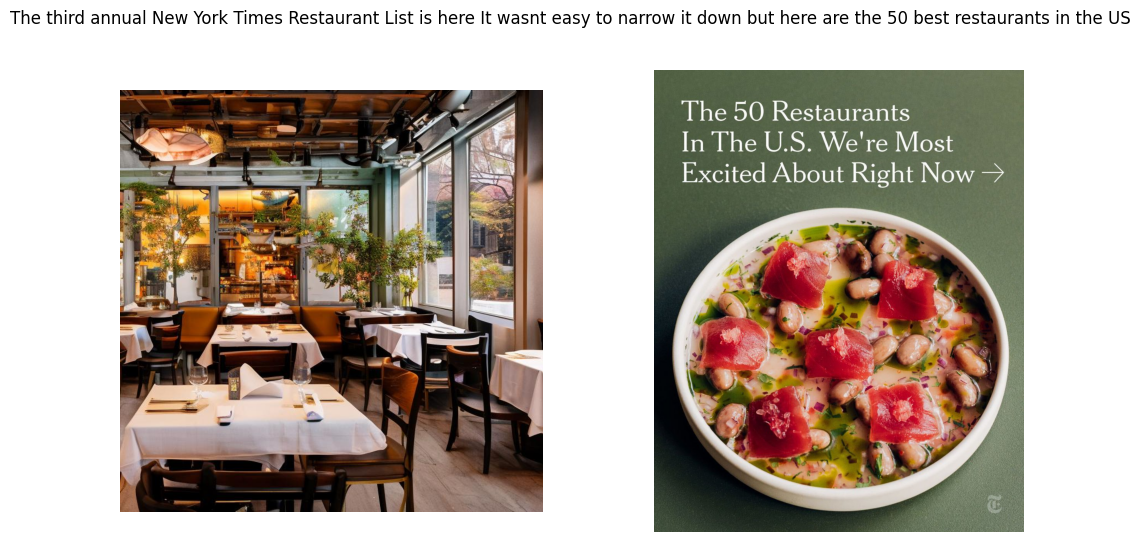

Similarity Score:0.59326171875


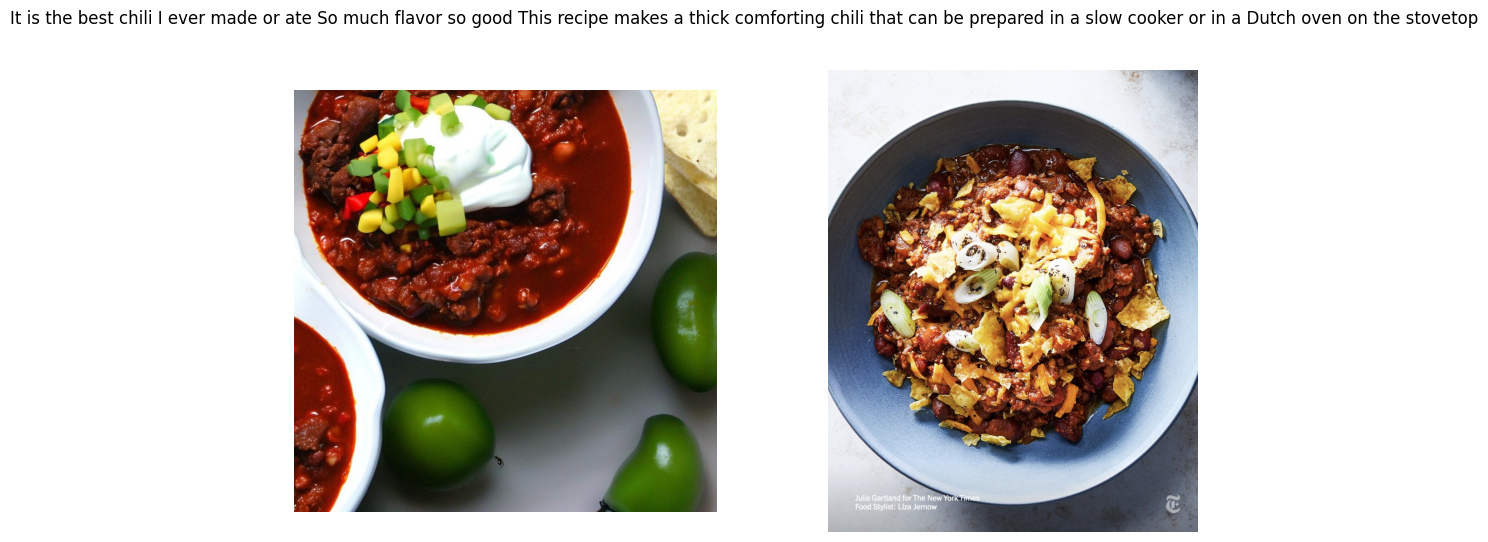

Similarity Score:0.751953125


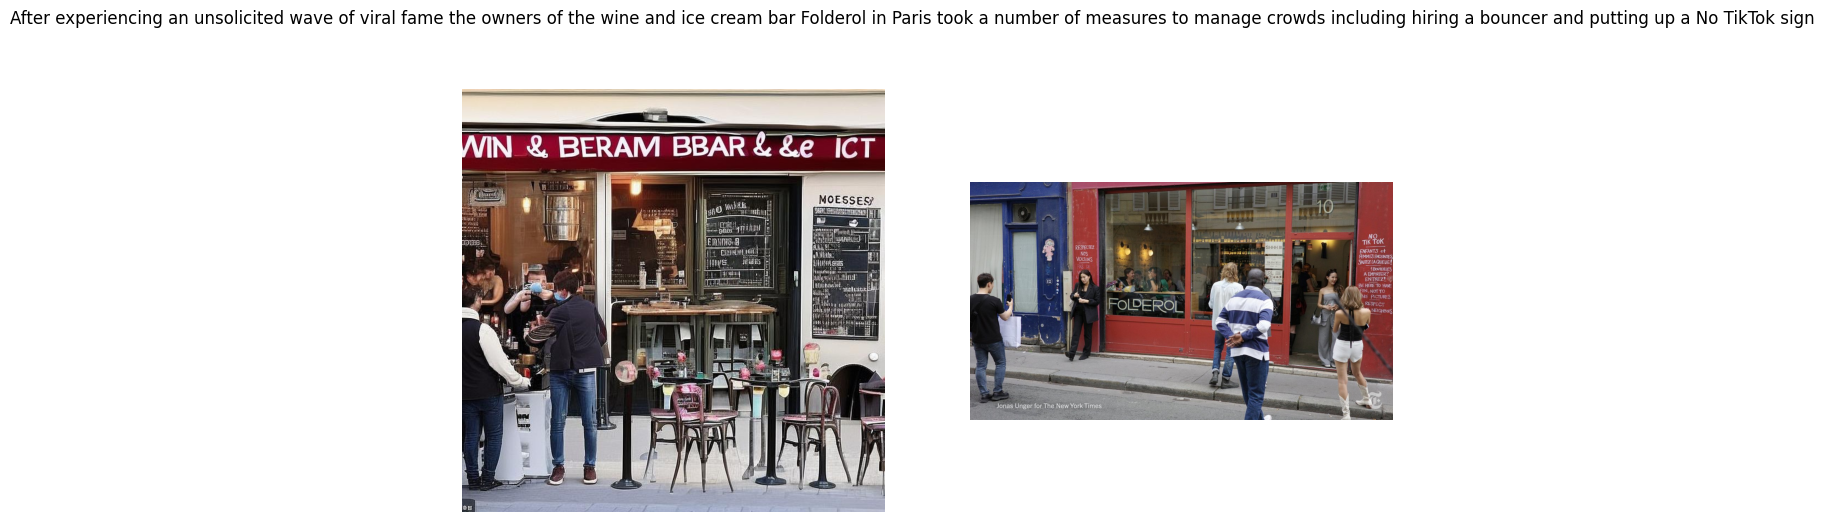

Similarity Score:0.6572265625


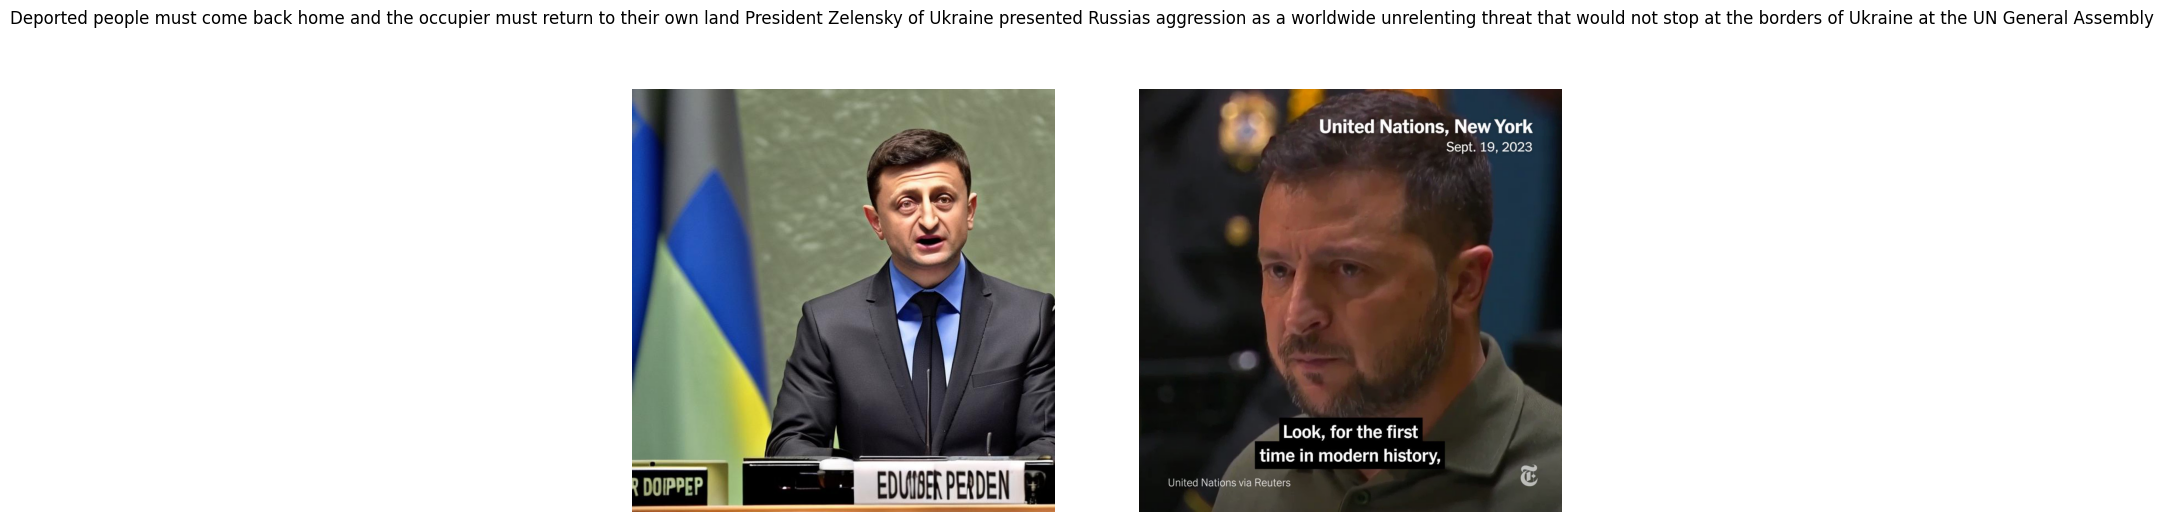

Similarity Score:0.51416015625


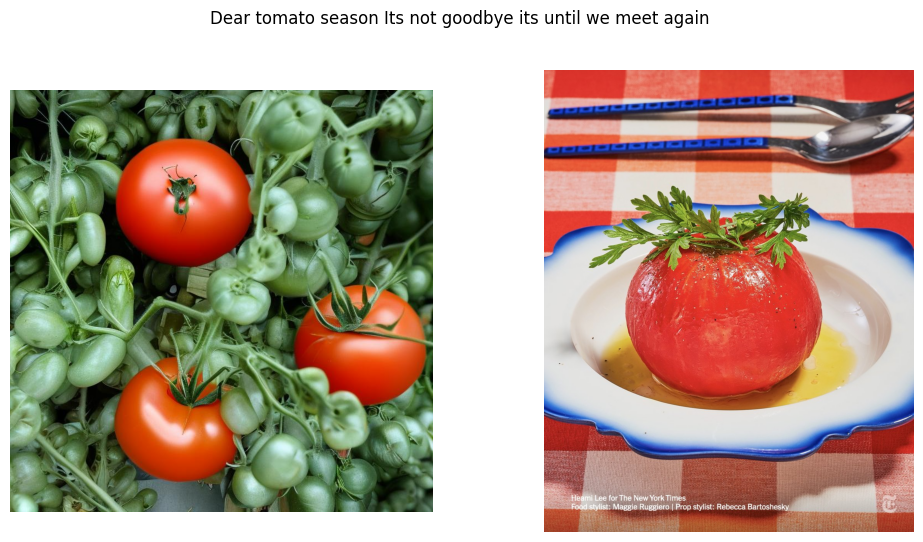

Similarity Score:0.7109375


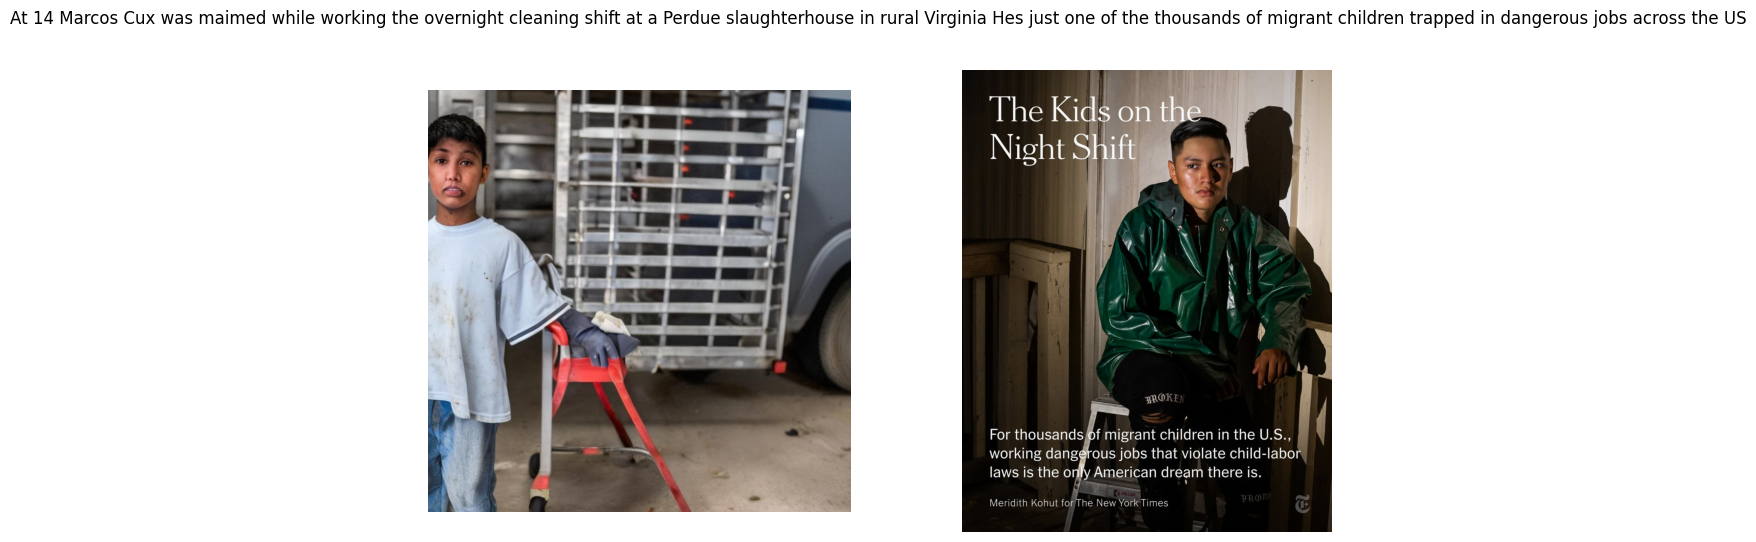

Similarity Score:0.6123046875


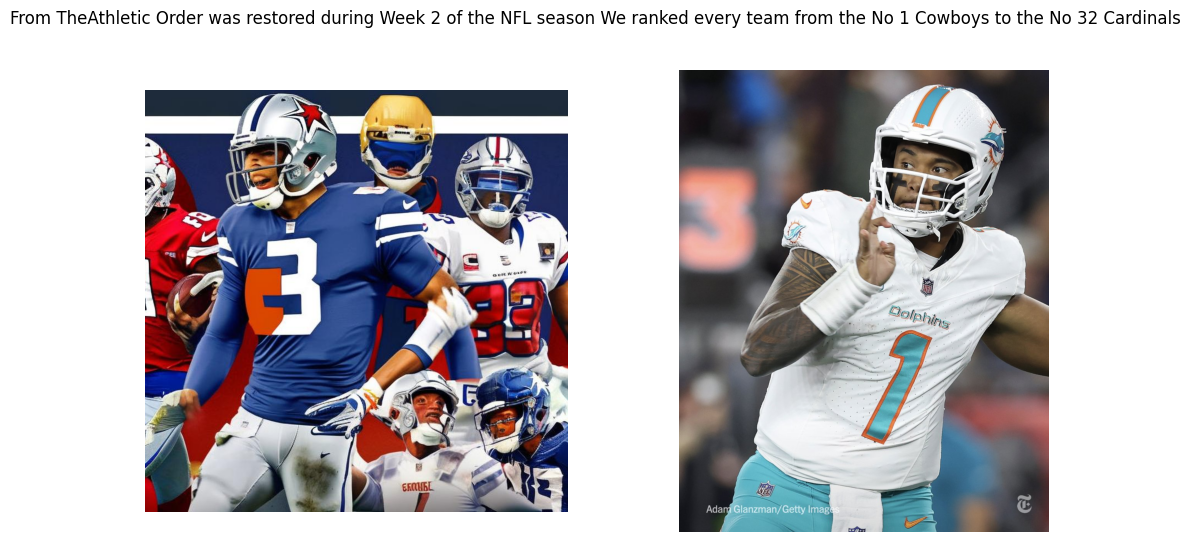

Similarity Score:0.73291015625


In [15]:
def load_image(image_id, image_dir):
    image_path = os.path.join(image_dir, f"{image_id}.jpg")
    if os.path.exists(image_path):
        return Image.open(image_path)
    else:
        return None

for i in range(len(prompts)):
    tweet = df.tweetContentProcessed[i]
    id = df.id[i]

    image1 = load_image(id, OUTPUT_DIR)
    image2 = load_image(id, ORIGINAL_DIR)
    score =  similarityScore(image1,image2)


    # Subpolts
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    ax1.imshow(image1)
    ax1.axis('off')
    ax2.imshow(image2)
    ax2.axis('off')

    fig.suptitle(tweet, fontsize=12)
    plt.show()

    print(f'Similarity Score:{score}')



In [17]:
# Code to zip the Images
shutil.make_archive('Data Generated', 'zip', OUTPUT_DIR)

'/content/Data Generated.zip'